In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
def plot_graphs(history, string):
      plt.plot(history.history[string])
      plt.plot(history.history['val_'+string])
      plt.xlabel("Epochs")
      plt.ylabel(string)
      plt.legend([string, 'val_'+string])
      plt.show()

In [3]:
def category_predict(quest):
    vocab_size = 7000
    embedding_dim = 256
    max_length = 15
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    
    stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "while", "with", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]
    punctuations = '''!()-[]{};:'"`\,<>./?@#$%^&*_~\n'''
    
    train_category = []
    train_subcategory = []
    train_questions = []

    with open('train_5500.label', 'r') as f:
        for line in f:
            split_index1 = line.index(":")
            split_index2 = line.index(" ")
            train_category.append(line[:split_index1])
            train_subcategory.append(line[split_index1+1:split_index2])
            train_questions.append(line[(split_index2+1):])
            
    for i in range(0,len(train_questions)):
        train_question = train_questions[i].lower()
    #     for word in stopwords:
    #         token = " " + word + " "
    #         train_question = train_question.replace(token, " ")
        no_punct = ''
        for char in train_question:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("  ", " ")
        train_questions[i] = no_punct
    
    test_category = []
    test_subcategory = []
    test_questions = []

    with open('TREC_10.label', 'r') as f:
        for line in f:
            split_index1 = line.index(":")
            split_index2 = line.index(" ")
            test_category.append(line[:split_index1])
            test_subcategory.append(line[split_index1+1:split_index2])
            test_questions.append(line[(split_index2+1):])
    
    for i in range(0,len(test_questions)):
        test_question = test_questions[i].lower()
    #     for word in stopwords:
    #         token = " " + word + " "
    #         test_question = test_question.replace(token, " ")
        no_punct = ''
        for char in test_question:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("  ", " ")
        test_questions[i] = no_punct

    ques=[]
    for i in range(0,len(quest)):
        ques1 = quest[i].lower()
#     for word in stopwords:
    #         token = " " + word + " "
    #         ques = ques.replace(token, " ")
        no_punct = ''
        for char in ques1:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("  ", " ")
        ques.append(no_punct)
    
    tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
    tokenizer.fit_on_texts(train_questions)
    word_index = tokenizer.word_index
#     print(word_index)

    train_sequences = tokenizer.texts_to_sequences(train_questions)
    train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
    
    test_sequences = tokenizer.texts_to_sequences(test_questions)
    test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
#     print(test_sequences)
    
    ques_sequences = tokenizer.texts_to_sequences(ques)
    ques_padded = pad_sequences(ques_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
    
    category_tokenizer = Tokenizer()
    category_tokenizer.fit_on_texts(train_category)
    category_word_index = category_tokenizer.word_index

    train_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(train_category)), maxlen=1)
    test_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(test_category)), maxlen=1)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'sigmoid'),
        tf.keras.layers.Dense(7, activation = 'softmax')])

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.002), metrics=['acc'])
    #model.summary()
    
    num_epochs = 10
    history = model.fit(train_padded, train_category_seq, epochs = num_epochs, validation_data=(test_padded, test_category_seq), verbose = 2)

    plot_graphs(history, "acc")
    plot_graphs(history, "loss")
    
    prediction = model.predict(ques_padded)
    print(ques)
#     print(ques_sequences)
#     print(ques_padded)
#     print(prediction)
#     print(category_word_index)
    for i in prediction:
#     x = i.find(max(i))
        x = (np.where(i == np.amax(i)))[0]
    #     print(x)
        for a in category_word_index:
            if category_word_index[a] == x:
                print(a)

Train on 5452 samples, validate on 500 samples
Epoch 1/10
5452/5452 - 43s - loss: 1.1388 - acc: 0.5666 - val_loss: 0.5821 - val_acc: 0.8500
Epoch 2/10
5452/5452 - 19s - loss: 0.4662 - acc: 0.8668 - val_loss: 0.4847 - val_acc: 0.8600
Epoch 3/10
5452/5452 - 18s - loss: 0.2706 - acc: 0.9287 - val_loss: 0.5711 - val_acc: 0.8340
Epoch 4/10
5452/5452 - 18s - loss: 0.1622 - acc: 0.9580 - val_loss: 0.5478 - val_acc: 0.8540
Epoch 5/10
5452/5452 - 18s - loss: 0.1050 - acc: 0.9756 - val_loss: 0.4767 - val_acc: 0.8660
Epoch 6/10
5452/5452 - 19s - loss: 0.0845 - acc: 0.9824 - val_loss: 0.4811 - val_acc: 0.8680
Epoch 7/10
5452/5452 - 18s - loss: 0.0651 - acc: 0.9877 - val_loss: 0.5943 - val_acc: 0.8560
Epoch 8/10
5452/5452 - 18s - loss: 0.0688 - acc: 0.9851 - val_loss: 0.5734 - val_acc: 0.8640
Epoch 9/10
5452/5452 - 19s - loss: 0.0530 - acc: 0.9881 - val_loss: 0.6303 - val_acc: 0.8620
Epoch 10/10
5452/5452 - 24s - loss: 0.0396 - acc: 0.9905 - val_loss: 0.5919 - val_acc: 0.8720


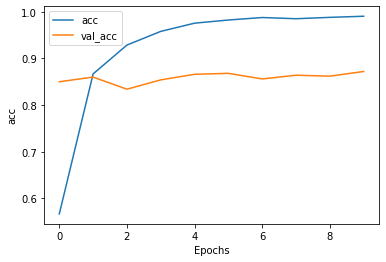

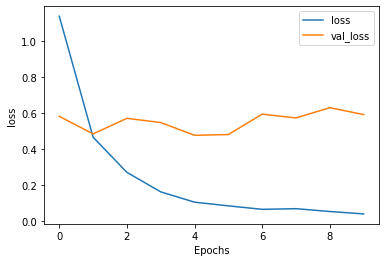

['who was bill gates ', 'where is mumbai located ', 'what is schrodinger s cat ', 'can earth be a planet ', 'how long does it take to dance ']
hum
loc
desc
desc
num


In [33]:
category_predict(["Who was Bill Gates ?", "Where is Mumbai located ?", "What is Schrodinger 's cat ?", "Can earth be a planet ?", "How long does it take to dance ?"])

In [15]:
print(category_word_index)
prediction = (model.predict(validation_padded[-10:]))
for i in prediction:
#     x = i.find(max(i))
    x = (np.where(i == np.amax(i)))[0]
#     print(x)
    for a in category_word_index:
        if category_word_index[a] == x:
            print(a)
    
# print(validation_category_seq[-10:])
print(validation_questions[-10:])

{'enty': 1, 'hum': 2, 'desc': 3, 'num': 4, 'loc': 5, 'abbr': 6}
desc
desc
enty
num
num
hum
enty
num
desc
desc
['what is pectin ', 'what is biodiversity ', 'what s the easiest way to remove wallpaper ', 'what year did the titanic start on its journey ', 'how much of an apple is water ', 'who was the 22nd president of the us ', 'what is the money they use in zambia ', 'how many feet in a mile ', 'what is the birthstone of october ', 'what is ecoli ']


In [4]:
subcategory_tokenizer = Tokenizer()
subcategory_tokenizer.fit_on_texts(subcategory)
subcategory_word_index = subcategory_tokenizer.word_index
print(subcategory_word_index)

training_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(train_subcategory)), maxlen=1)
validation_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(validation_subcategory)), maxlen=1)

NameError: name 'subcategory' is not defined

In [18]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(120, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'sigmoid'),
    tf.keras.layers.Dense(48, activation = 'softmax')
])

model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 256)           1792000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 15, 192)           271104    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 48)                3120      
Total params: 2,206,064
Trainable params: 2,206,064
Non-trainable params: 0
____________________________________________

In [19]:
num_epochs = 20
history1 = model1.fit((train_padded, training_category_seq), training_subcategory_seq, epochs = num_epochs, validation_data=((validation_padded[:-10], validation_category_seq[:-10]), validation_subcategory_seq[:-10]), verbose = 2)

Train on 5452 samples, validate on 490 samples
Epoch 1/20
5452/5452 - 23s - loss: 3.0132 - acc: 0.2177 - val_loss: 2.7058 - val_acc: 0.2633
Epoch 2/20
5452/5452 - 15s - loss: 2.2234 - acc: 0.4110 - val_loss: 2.3311 - val_acc: 0.2857
Epoch 3/20
5452/5452 - 14s - loss: 1.8277 - acc: 0.5061 - val_loss: 2.1588 - val_acc: 0.3755
Epoch 4/20
5452/5452 - 14s - loss: 1.5671 - acc: 0.5941 - val_loss: 1.9549 - val_acc: 0.5347
Epoch 5/20
5452/5452 - 14s - loss: 1.3220 - acc: 0.6640 - val_loss: 1.7710 - val_acc: 0.5918
Epoch 6/20
5452/5452 - 13s - loss: 1.1283 - acc: 0.7045 - val_loss: 1.7105 - val_acc: 0.6020
Epoch 7/20
5452/5452 - 13s - loss: 0.9453 - acc: 0.7599 - val_loss: 1.6872 - val_acc: 0.6245
Epoch 8/20
5452/5452 - 13s - loss: 0.8411 - acc: 0.7825 - val_loss: 1.6388 - val_acc: 0.6714
Epoch 9/20
5452/5452 - 13s - loss: 0.7262 - acc: 0.8168 - val_loss: 1.6231 - val_acc: 0.6490
Epoch 10/20
5452/5452 - 13s - loss: 0.6335 - acc: 0.8430 - val_loss: 1.6499 - val_acc: 0.6510
Epoch 11/20
5452/5452 

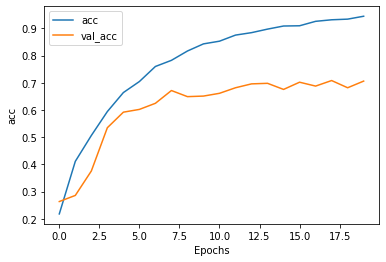

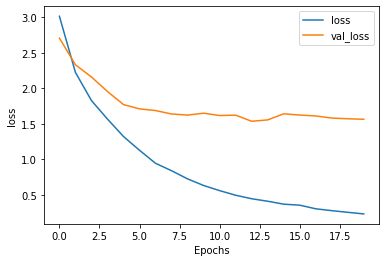

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history1, "acc")
plot_graphs(history1, "loss")

In [21]:
print(subcategory_word_index)
prediction = (model1.predict((validation_padded[-10:], validation_category_seq[:-10])))
for i in prediction:
    x = (np.where(i == np.amax(i)))[0]
    print(x)
    for a in subcategory_word_index:
        if subcategory_word_index[a] == x:
            print(a)
    
print(validation_subcategory_seq[-10:])
print(validation_questions[-10:])

{'ind': 1, 'other': 2, 'def': 3, 'count': 4, 'desc': 5, 'manner': 6, 'date': 7, 'cremat': 8, 'reason': 9, 'gr': 10, 'country': 11, 'city': 12, 'animal': 13, 'food': 14, 'dismed': 15, 'termeq': 16, 'period': 17, 'money': 18, 'exp': 19, 'state': 20, 'sport': 21, 'event': 22, 'product': 23, 'substance': 24, 'color': 25, 'techmeth': 26, 'dist': 27, 'perc': 28, 'veh': 29, 'word': 30, 'title': 31, 'mount': 32, 'body': 33, 'abb': 34, 'lang': 35, 'plant': 36, 'volsize': 37, 'symbol': 38, 'weight': 39, 'instru': 40, 'letter': 41, 'speed': 42, 'code': 43, 'temp': 44, 'ord': 45, 'religion': 46, 'currency': 47}
[3]
def
[3]
def
[26]
techmeth
[7]
date
[4]
count
[1]
ind
[15]
dismed
[4]
count
[2]
other
[3]
def
[[ 3]
 [ 3]
 [26]
 [ 7]
 [ 4]
 [ 1]
 [47]
 [ 4]
 [24]
 [ 3]]
['what is pectin ', 'what is biodiversity ', 'what s the easiest way to remove wallpaper ', 'what year did the titanic start on its journey ', 'how much of an apple is water ', 'who was the 22nd president of the us ', 'what is the mone